### Initialize

In [1]:
# Define Program Version 
__ver__ = '01'

In [2]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets as widgets
from IPython.display import display

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

Updating the local database...
Done


In [3]:
# Bunch of functions 

def lorentzian_fitfun(f, f0, gamma, amp=1, offset=0):
    return amp * (gamma/2)**2 / ((f-f0)**2 + (gamma/2)**2) + offset

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort_values('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.imagedata.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

def mesh_for_2d_plot(x, y, z):
    x1 = np.concatenate([ [2*x[0] - x[1]], x])
    x2 = np.concatenate([x, [2*x[-1] - x[-2]]])
    x = np.mean([x1, x2], axis=0)

    y1 = np.concatenate([ [2*y[0] - y[1]], y])
    y2 = np.concatenate([y, [2*y[-1] - y[-2]]])
    y = np.mean([y1, y2], axis=0)
    
    return (x, y, z)

def fourier_transform(curve, k):
    return np.array([np.trapz(curve.y * np.exp(-1j * ki * curve.x) , curve.x) for ki in k])


In [4]:
# Useful snippets 

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=1000, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )



In [5]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.9):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.9, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N



# In Situ Density Modulation

In [2422]:
# Some Fitting functions 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x

In [2444]:
# Desplay widgets to select various parameters 

# All the variables to load 
var = ['ExpansionTime','SideGreenEvap','WaitBox',
       'IREvap','HeatTime','ShakeTime','ShakeWait', 'HeatCycles',
       'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime']

fontsize = 15

# Saving and Loading widgets 
WID_SaveAnalyzedDataBtn = widgets.Button( description='Save Data', button_style='success', )
WID_Folder = widgets.Text( value='AnalyzedData', placeholder='Type Folder to store data', description='Save Folder :')
WID_DatasetType = widgets.Text( value='InsituShakingVsFreq', placeholder='Type Dataset Type/Information', description='Dataset Type :',)
WID_DatasetDate = widgets.Text( value='06_22_2017', placeholder='Type Dataset Date, E.x. 06_15_2017', description='Dataset Date :',)
WID_DatasetName = widgets.Text( value='DS3', placeholder='Type Dataset Name, E.x. DS1', description='Dataset Name :',)

# Select a Particular x_variable
WID_x_var = widgets.ToggleButtons(description='x variable = = > ', 
            options=['ShakeWait', 'ShakingCycles', 'BoxShakeFreq', 'BoxShakeAmp', 'HeatCycles'])
display(WID_x_var)

# Select a Particular x_variable
WID_using_image = widgets.ToggleButtons(description='Image Selection = = > ', 
            options=['A', 'B', 'Both'])
display(WID_using_image)

# Select a Particular X_Label for the plots 
WID_xlabel = widgets.ToggleButtons(description='xlabel for plots = > ', 
            options=['Waittime (ms)', 'Shaking Cycles', 'Shaking Frequency (Hz)', 'Shaking Amplitude (Cicero Volts)', 'Heating Cycles'])
display(WID_xlabel)

# Reduced Plots and Info for Faster Processing 
WID_info = widgets.Checkbox( value=True, description='Show all info plots',)
display(WID_info)

# Additional WID used later 
WID_atoms_keep = widgets.FloatSlider(value=0.07, min=0.01, max=0.4, step=0.01,
                description='Atom Num Selection:', readout=True, readout_format='.2f',
                layout=widgets.Layout(width='50%'), )

WID_height = widgets.IntSlider(value=181, min=105, max=219, step=2,
             description='Height:', readout=True, layout=widgets.Layout(width='50%'), )

WID_width = widgets.IntSlider(value=75, min=15, max=177, step=2,
             description='Width:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_x = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center X:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_y = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center Y:', readout=True, layout=widgets.Layout(width='50%'), )

WID_clim_dN = widgets.FloatSlider(value=0.15, min=0.01, max=0.50, step=0.001,
                description='clim for dN:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

WID_clim_dN_N = widgets.FloatSlider(value=0.15, min=0.01, max=0.5, step=0.001,
                description='clim for dN/N:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

In [3691]:
# ONLY ONCE -- Initialize empty dataframe and select options 
df_all = get_from_clipboard(init=True)

## Load Data from Images

In [3692]:
# Import from Clipboard 
x_var = WID_x_var.value
using = 0 if WID_using_image.value == 'A' else 1 if WID_using_image.value == 'B' else 2
info = WID_info.value
df_all = get_from_clipboard(df=df_all, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=using, display=info)
if WID_info.value:
    df_all.head(5) 


Updating the local database...
Done
Pasted Sample :  ['08-02-2017_16_01_24_TopA', '08-02-2017_16_01_24_TopB']
Newly added images       : 47
Total number of images   : 47


08-02-2017_15_14_37_TopA
0.1


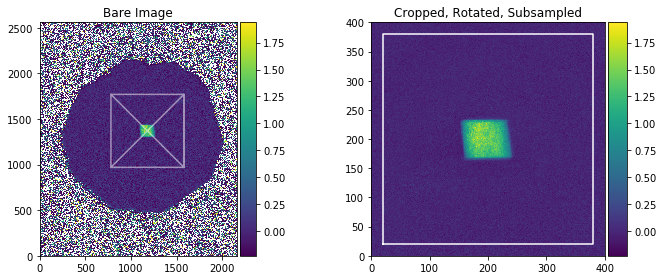

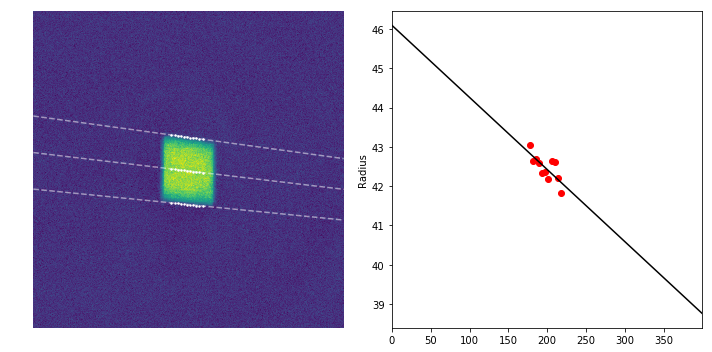

In [3693]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1181, center_y = 1370, width=800, height=800, fudge=1.75, subsample=2, 
                  xsec_extension='linear', xsec_slice_width=4, xsec_fit_range=1.0, radial_selection=0.5,)}

# Apply settings
for i, r in df_all.iterrows():
    r.image.set(**settings)
    
# Tests
if WID_info.value: 
    test = 0
    print(df_all.image.iloc[test].name)
    df_all.image.iloc[test].plot_crop()
    print(df_all.x.iloc[test])
    plt.show()
    fig, ax = plt.subplots(ncols=2, figsize=[10, 5])
    df_all.image.iloc[test].xsec.infoplot(axs=ax)
    plt.tight_layout()


All Images 47; Data 32; BG 7
Fudge   1.75
Volume  977896 um^3
Atom #  0.504 +- 0.021 
Density 0.515 +- 0.021 um^-3
E_F     8.20 +- 0.23 kHz
v_F     32.99 um/ms


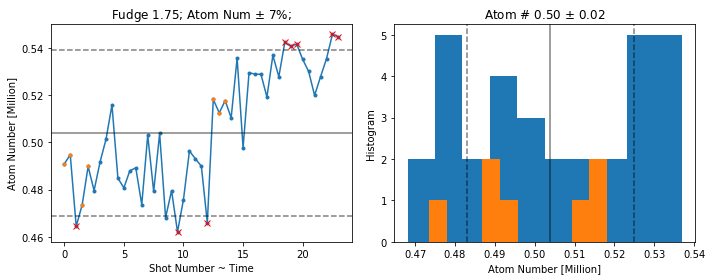

In [3694]:
# Atom numbers filter, sort data and bg, print information 

# Parameters 
display(WID_atoms_keep)

df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image, desc='Atoms')]
using = atom_num_filter(df_all, keep=WID_atoms_keep.value, offset=0.0, plot=False)

# Extract data and background 
bg_select = ['ShakingCycles', 0]
df_data = df_all[(df_all[bg_select[0]] != 0) & using]
df_bg = df_all[(df_all[bg_select[0]] == 0) & using]
df_bad = df_all[~using]

# Extract relavant information 
info = {}
info['Images Data'] = df_data.shape[0]
info['Images BG'] = df_bg.shape[0]
info['Fudge'] = df_all.image.iloc[0].fudge
info['Atoms'] = np.mean(df_all[using].total_atoms)
info['Atoms Error'] = np.std(df_all[using].total_atoms)
info['Cross Section Guess'] = np.pi * (59.38e-6)**2
info['Box Length Guess'] = 88.28e-6
info['Volume'] = info['Box Length Guess'] * info['Cross Section Guess']
info['Density'] = info['Atoms'] / info['Volume']
info['Density Error'] = info['Atoms Error'] / info['Volume']
info['EF'] = np.mean(cst.n2EF(df_all[using].total_atoms / info['Volume']))
info['EF Error'] = np.std(cst.n2EF(df_all[using].total_atoms / info['Volume']))
info['vF'] = ((2 * info['EF']) / (cst.mass))**(1/2)

print('All Images {}; Data {}; BG {}'.format(df_all.shape[0], df_data.shape[0], df_bg.shape[0]))
print('Fudge  ', info['Fudge'])
print('Volume  {:.0f} um^3'.format(info['Volume']*1e18))
print('Atom #  {:.3f} +- {:.3f} '.format(info['Atoms']/1e6, info['Atoms Error']/1e6))
print('Density {:.3f} +- {:.3f} um^-3'.format(info['Density']/1e18, info['Density Error']/1e18))
print('E_F     {:.2f} +- {:.2f} kHz'.format(info['EF']/kHz, info['EF Error']/kHz))
print('v_F     {:.2f} um/ms'.format(info['vF'] * 1e3))

if WID_info.value: 
    fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
    ax[0].plot(df_all.shot, df_all.total_atoms/1e6, 'C0.-', 
               df_bad.shot, df_bad.total_atoms/1e6, 'rx',
               df_bg.shot, df_bg.total_atoms/1e6, 'C1.')
    ax[0].axhline(info['Atoms'] / 1e6, linestyle='-', c='k', alpha=0.5)
    ax[0].axhline(info['Atoms'] / 1e6 * (1 + WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax[0].axhline(info['Atoms'] / 1e6 * (1 - WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax[0].set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]', 
              title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(info['Fudge'], WID_atoms_keep.value*100))
    ax[1].hist(df_data.total_atoms/1e6)
    ax[1].hist(df_bg.total_atoms/1e6)
    ax[1].axvline(info['Atoms'] / 1e6, linestyle='-', c='k', alpha=0.5)
    ax[1].axvline(info['Atoms'] / 1e6 + info['Atoms Error']/1e6, linestyle='--', c='k', alpha=0.5)
    ax[1].axvline(info['Atoms'] / 1e6 - info['Atoms Error']/1e6, linestyle='--', c='k', alpha=0.5)
    ax[1].set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f}'.format(info['Atoms']/1e6, info['Atoms Error']/1e6))
    plt.tight_layout()
    plt.show()


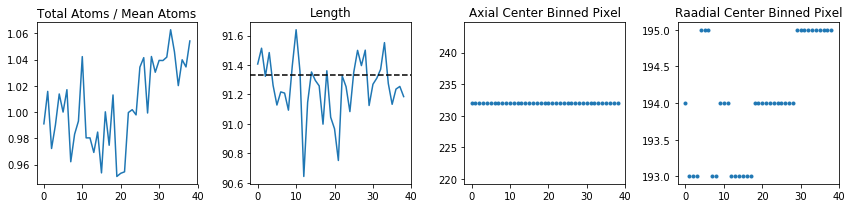

In [3695]:
# Get right_edge, length, offset, integral, central_pixel : for all 

# Function definitions 
guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x

# Fitter -- 0:RigthEdge (center), 1:Length, 2:Offset, 3:Integral, 4:RightEdgePixel
subsample = df_bg.iloc[0].image.subsample
def fit_and_extract(nz):
    fr, fe = nz.fit(fitfun_erf, guess, plot=False)
    return [fr[1], fr[1]-fr[0], fr[5], np.trapz(nz.y - fr[5], nz.x), np.argmin(np.abs(nz.x - fr[1]))]

# center and rescale
def center_and_rescale(nz, center, length, offset, rescale):
    return tp.Curve(nz.x - center + length, (nz.y - offset) / np.trapz(nz.y - offset, nz.x) * rescale, 
                    xscale=nz.xscale, yscale=nz.yscale)

# Fit all data 
erf_fit = np.array([fit_and_extract(im.nz) for im in tqdm(df_bg.image)])
df_bg['z_offset'], df_bg['length'], df_bg['n_offset'], df_bg['integral'], df_bg['z_offset_pixel'] = erf_fit.T
erf_fit = np.array([fit_and_extract(im.nz) for im in tqdm(df_data.image)])
df_data['z_offset'], df_data['length'], df_data['n_offset'], df_data['integral'], df_data['z_offset_pixel'] = erf_fit.T

# Calculate radial_center_pixeol
df_bg['radial_center_pixel'] = [np.round(r.image.xsec.get_center(r.z_offset_pixel)) for i, r in df_bg.iterrows()]
df_data['radial_center_pixel'] = [np.round(r.image.xsec.get_center(r.z_offset_pixel)) for i, r in df_data.iterrows()]

# Get averaged length and error 
info['Box Length Fit'] = np.mean(df_bg['length'])
info['nz rescale'] = np.mean(np.concatenate([df_bg['integral'].values]))
# info['nz rescale'] = np.mean(np.concatenate([df_bg['integral'].values, df_data['integral'].values]))

# center and rescale n(z)
df_bg['nz'] = [center_and_rescale(r.image.nz, r.z_offset, info['Box Length Fit'], r.n_offset, info['nz rescale']) for i,r in df_bg.iterrows()]
df_data['nz'] = [center_and_rescale(r.image.nz, r.z_offset, info['Box Length Fit'], r.n_offset, info['nz rescale']) for i,r in df_data.iterrows()]

# Plot the scatter 
plt.figure(figsize=[12, 3])
plt.subplot(141)
plt.plot(np.concatenate([df_bg['integral'].values, df_data['integral'].values]) / info['nz rescale'])
plt.title('Total Atoms / Mean Atoms')
plt.subplot(142)
plt.plot(np.concatenate([df_bg['length'].values, df_data['length'].values])*1e6, '-')
plt.axhline(info['Box Length Fit']*1e6, c='k', linestyle='--')
plt.title('Length')
plt.subplot(143)
plt.plot(np.concatenate([df_bg['z_offset_pixel'].values, df_data['z_offset_pixel'].values]), '.')
plt.title('Axial Center Binned Pixel')
plt.subplot(144)
plt.plot(np.concatenate([df_bg['radial_center_pixel'].values, df_data['radial_center_pixel'].values]), '.')
plt.title('Raadial Center Binned Pixel')
plt.tight_layout()

In [3696]:
# Average Profiles -- n(z) 

# Inputs
z_lims = np.array([-50, 140]) * 1e-6

# Background 
nz_bg_conc = tp.Curve(np.concatenate([nz.x for nz in df_bg.nz]), np.concatenate([nz.y for nz in df_bg.nz]), 
                      xscale=1e-6, yscale=1).sortbyx()
nz_bg = nz_bg_conc.binbyx(step = np.diff(df_bg.iloc[0].nz.x)[0])

# Raw Data 
x_list = df_data.x.values
z_list = nz_bg.trim(xlim = z_lims).x.copy()
movie_dN_raw = [x_list, z_list*1e6, 
                np.array([nz_data(z_list) - nz_bg(z_list) for nz_data in df_data.nz]).T]
movie_dN_N_raw = [x_list, z_list*1e6, 
                  np.array([(nz_data(z_list) - nz_bg(z_list)) / (nz_bg(z_list)) for nz_data in df_data.nz]).T]

# Average Data 
x_list = np.unique(df_data.x.values)
z_list = nz_bg.trim(xlim = z_lims).x.copy()
nz_data_conc = []
nz_data = []
movie_dN = []
movie_dN_N = []

for x in x_list:
    # Grab the relevant data 
    df_ = df_data[df_data.x == x]
    
    # Average n(z)
    nz_data_conc.append(tp.Curve(np.concatenate([nz.x for nz in df_.nz]), np.concatenate([nz.y for nz in df_.nz]), 
                      xscale=1e-6, yscale=1).sortbyx())
    nz_data.append(nz_data_conc[-1].binbyx(step = np.diff(df_bg.iloc[0].nz.x)[0]))
    
    # Get dN and dN/N
    movie_dN.append( (nz_data[-1](z_list) - nz_bg(z_list)) )
    movie_dN_N.append( (nz_data[-1](z_list) - nz_bg(z_list)) / (nz_bg(z_list)) )

movie_dN = [x_list, z_list*1e6, np.array(movie_dN).T]
movie_dN_N = [x_list, z_list*1e6, np.nan_to_num(np.array(movie_dN_N).T)]

In [3697]:
# # Averaging Profiles -- Old school way -- ROI 

# # roi settings and trap center 
# display(WID_height)
# display(WID_width)
# display(WID_center_x)
# display(WID_center_y)

# width = WID_width.value // settings['subsample']
# height = WID_height.value // settings['subsample']
# center = [WID_center_x.value // settings['subsample'],WID_center_y.value // settings['subsample']]
# plot_buffer = [25, 7]
# roi = get_roi(data=df_bg.image.iloc[0].app, center=center, width=width, height=height)

# # Average all BG images
# bg_app = np.nanmean([im.app for im in df_bg.image], axis=0)
# bg_curve = tp.Curve(y = np.mean(bg_app[:,roi[1]], axis=1))

# # Trap Center and Box Length Fits 
# guess_width = 80e-6 / df_bg.iloc[0].image.pixel_binned / 2
# guess_sigma = 10e-6 / df_bg.iloc[0].image.pixel_binned 
# guess = [bg_curve.maxx//2 - guess_width, bg_curve.maxx//2 + guess_width, 
#          guess_sigma, guess_sigma, bg_curve.maxy, bg_curve.y[0], bg_curve.y[0]/bg_curve.maxx]
# bg_curve.removenan()
# fr, fe = bg_curve.fit(fitfun_erf, guess, plot=False)
# box_center = np.mean([fr[1], fr[0]])
# box_length = abs(fr[1] - fr[0])
# info['Box Length Fit'] = box_length * df_bg.iloc[0].image.pixel_binned 
# print('Box Length from Fit : {:.2f} um'.format(info['Box Length Fit'] * 1e6))

# # Function to calculate 1d density from cropped app 
# def calc_1d_profile(app):
#     y = np.nanmean(app, axis=1)
#     return y / np.mean(y)

# # Calculate 1D profile for all images 
# df_data['profile'] = [calc_1d_profile(im.app[roi]) for im in df_data.image]
# df_bg['profile'] = [calc_1d_profile(im.app[roi]) for im in df_bg.image]
# bg_profile = np.mean(df_bg.profile, axis=0)

# # Create 2D movie 
# x = np.unique(df_data.x)
# y = (np.arange(df_data.iloc[0].image.app.shape[0])[roi[0]] - box_center + box_length/2 ) * df_data.image.iloc[0].pixel_binned * 1e6
# z_difference = np.array([np.mean([p for p in df_data.profile[df_data.x == xi]], axis=0) - bg_profile for xi in x]).T
# z_percent = np.array([(np.mean([p for p in df_data.profile[df_data.x == xi]], axis=0) - bg_profile)/bg_profile for xi in x]).T
# movie_dN = [x, y, z_difference]
# movie_dN_N = [x, y, z_percent]

# # Plot
# if True:
#     # Plot
#     fig, ax = plt.subplots(ncols=3, figsize=[13, 5])
#     ax[0].imshow(bg_app, origin=0)
#     ax[0].axhline(roi[0].start, c='w', linestyle='--', alpha=0.5)
#     ax[0].axhline(roi[0].stop-1, c='w', linestyle='--', alpha=0.5)
#     ax[0].axvline(roi[1].start, c='w', linestyle='--', alpha=0.5)
#     ax[0].axvline(roi[1].stop-1, c='w', linestyle='--', alpha=0.5)
#     ax[0].set(xlim=[roi[1].start - plot_buffer[0], roi[1].stop + plot_buffer[0]], 
#               ylim=[roi[0].start - plot_buffer[1], roi[0].stop + plot_buffer[1]])
#     ax[1].plot(bg_curve.y, bg_curve.x)
#     ax[1].plot(bg_curve.xyfitplot[1], bg_curve.xyfitplot[0])
#     ax[1].axhline(roi[0].start, c='k', linestyle='-', alpha=0.5)
#     ax[1].axhline(roi[0].stop-1, c='k', linestyle='-', alpha=0.5)
#     ax[1].axhline(fr[0], c='k', linestyle='--', alpha=0.5)
#     ax[1].axhline(fr[1], c='k', linestyle='--', alpha=0.5)
#     ax[1].set(ylim=[roi[0].start - plot_buffer[1], roi[0].stop + plot_buffer[1]], xlim=[0, None])
#     ax[2].imshow(bg_app[roi], origin=0)
#     plt.tight_layout()

In [3698]:
plot_xi = 0

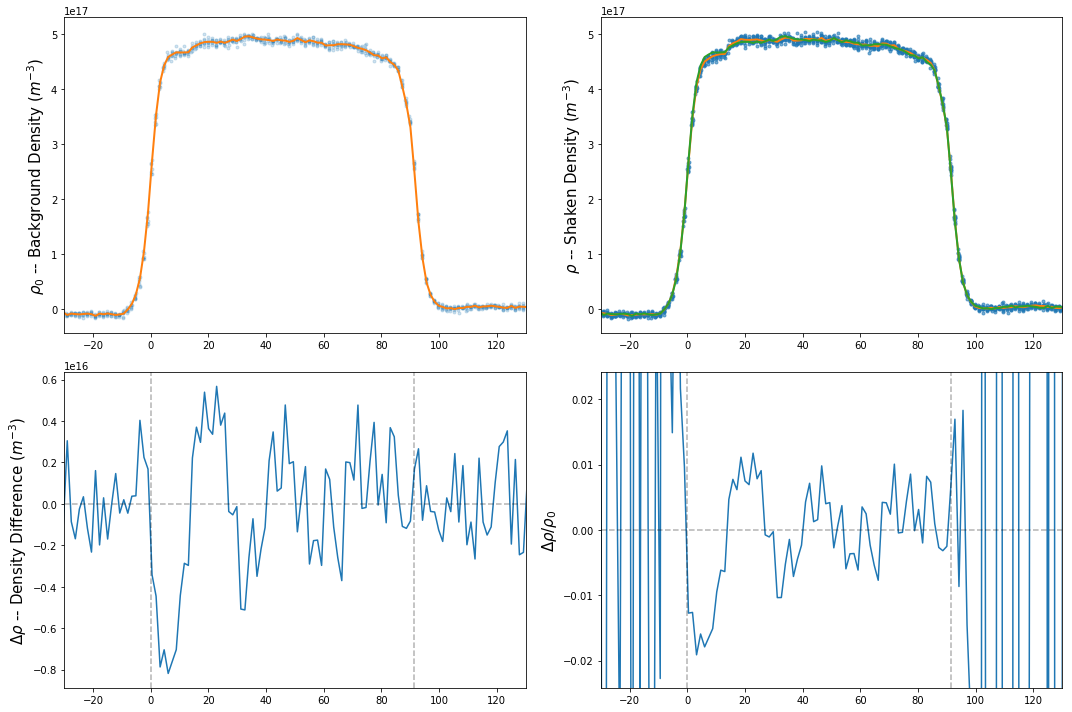

In [3699]:
# plot 
xi = plot_xi
plt.figure(figsize=[15, 10])
ax1 = plt.subplot(221)
plt.plot(*nz_bg_conc.plotdata, '.', alpha=0.2)
plt.plot(*nz_bg.plotdata, '-', linewidth=2)
plt.ylabel(r'$\rho_0$ -- Background Density ($m^{-3}$)', fontsize=15)

ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
plt.plot(*nz_data_conc[xi].plotdata, '.', alpha=0.6)
plt.plot(*nz_data[xi].plotdata, '-', linewidth=2)
plt.plot(*nz_bg.plotdata, '-', linewidth=2)
# plt.ylim([nz_bg.plotdata[1].max() * 0.5, None])
plt.ylabel(r'$\rho$ -- Shaken Density ($m^{-3}$)', fontsize=15)

ax3 = plt.subplot(223, sharex = ax1)
plt.plot(movie_dN[1], movie_dN[2][:, xi])
plt.axhline(0, c='k', linestyle='--', alpha=0.3)
plt.axvline(0, c='k', linestyle='--', alpha=0.3)
plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', alpha=0.3)
plt.ylabel(r'$\Delta \rho$ -- Density Difference ($m^{-3}$)', fontsize=15)

ax4 = plt.subplot(224, sharex = ax1)
plt.plot(movie_dN_N[1], movie_dN_N[2][:, xi])
plt.axhline(0, c='k', linestyle='--', alpha=0.3)
plt.axvline(0, c='k', linestyle='--', alpha=0.3)
plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', alpha=0.3)
appx_amp = np.abs(movie_dN_N[2][(movie_dN_N[1]>5) & (movie_dN_N[1]<50), xi]).max() * 1.35
plt.ylim([- appx_amp, appx_amp])
plt.ylabel(r'$\Delta \rho / \rho_0$', fontsize=15)

plt.xlim([-30, 130])

plt.tight_layout()

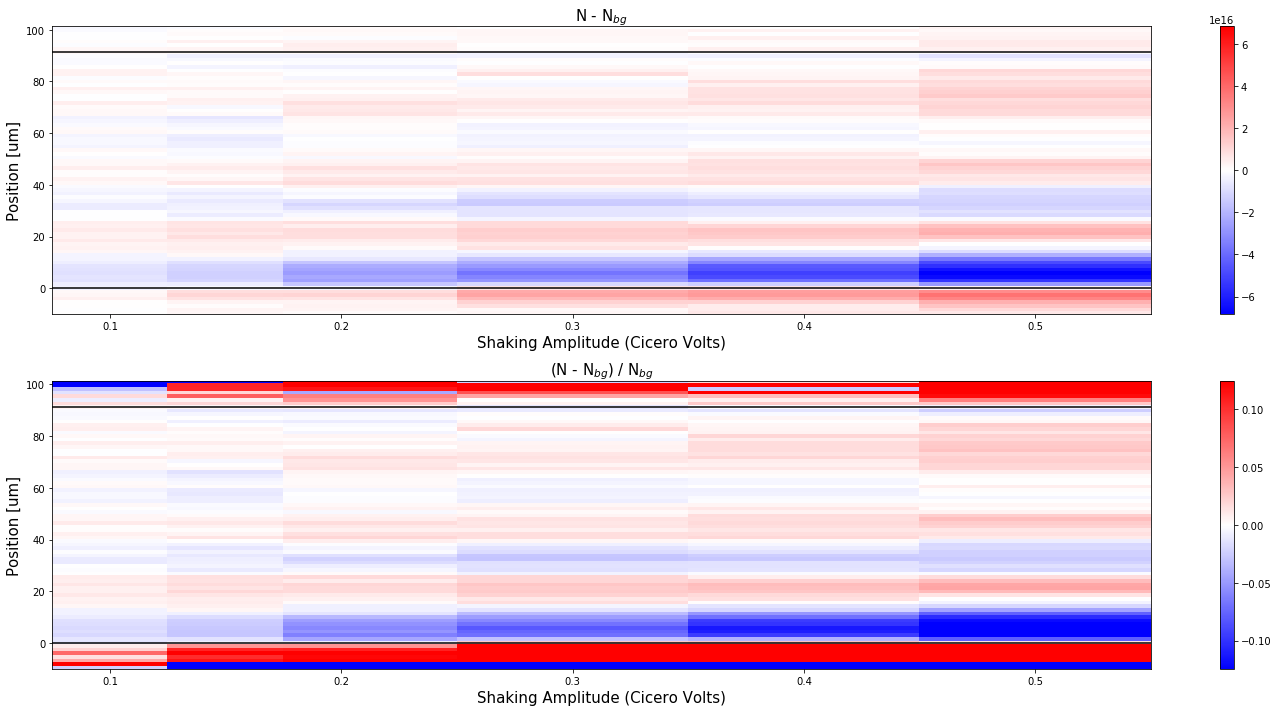

In [3700]:
# Generate 1D density for all, and normalize mean of values so the peak is around 1 

# Plot 
cmap = 'bwr' # viridis, bwr
zlim_pad = [-10, 10]
clim_dN_N_pad = 1.2

# Data 
x, y = movie_dN[0:2]
L = info['Box Length Fit']*1e6
clim_dN = np.max(np.abs(movie_dN[2]))
clim_dN_N = np.max(np.abs( movie_dN_N[2][(y>10) & (y<(L-10)), :] )) * clim_dN_N_pad

if len(x) > 1:
    fig = plt.figure(figsize=[20, 10])
    plt.subplot(211)
    plt.pcolormesh(*mesh_for_2d_plot(*movie_dN), vmin=- clim_dN , vmax=clim_dN, cmap=cmap)
    plt.axhline(0, c='k', linestyle='-', )
    plt.axhline(L, c='k', linestyle='-', )
    plt.colorbar()
    plt.title(r'N - N$_{bg}$', fontsize=fontsize)
    plt.ylabel('Position [um]', fontsize=fontsize)
    plt.xlabel(WID_xlabel.value, fontsize=fontsize)
    plt.ylim([zlim_pad[0], zlim_pad[1]+L])
    plt.subplot(212)
    plt.pcolormesh(*mesh_for_2d_plot(*movie_dN_N), vmin=- clim_dN_N, vmax=clim_dN_N, cmap=cmap)
    plt.axhline(0, c='k', linestyle='-', )
    plt.axhline(L, c='k', linestyle='-', )
    plt.colorbar()
    plt.xlabel(WID_xlabel.value, fontsize=fontsize)
    plt.ylabel('Position [um]', fontsize=fontsize)
    plt.ylim([zlim_pad[0], zlim_pad[1]+L])
    plt.title(r'(N - N$_{bg}$) / N$_{bg}$', fontsize=fontsize)
    plt.tight_layout()

# plot single 
if len(x) == 1:
    x, y, z = movie_dN
    plt.plot(y, z)
    plt.axvline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axvline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axhline(0, c='k', linestyle='-', alpha=0.5)
    
    

[ 0.1   0.15  0.2   0.3   0.4   0.5 ]


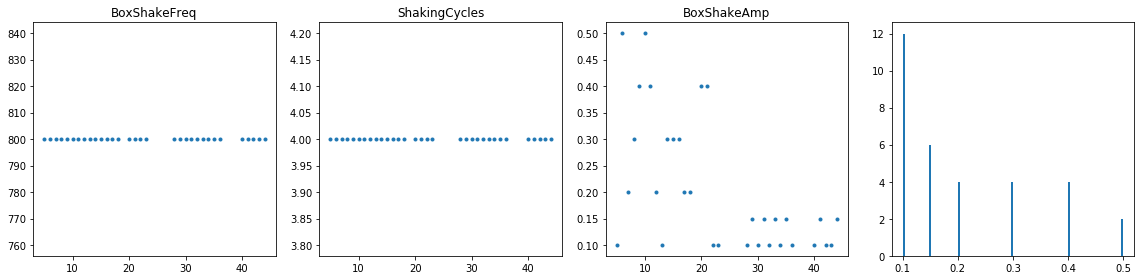

In [3701]:
# Plot of variables 
track = ['BoxShakeFreq', 'ShakingCycles', 'BoxShakeAmp', 'x']

ax = plt.subplots(ncols=len(track), figsize=[4 * len(track), 4])[1].flatten()
for i, t in enumerate(track[0:-1]):
    ax[i].plot(df_data[t], '.')
    ax[i].set(title=t)
ax[-1].hist(df_data[track[-1]], 100)
plt.tight_layout()

print(np.unique(df_data.x))

## FT Wavelength 

In [3702]:
# FT Setup 
L = info['Box Length Fit']
k = np.arange(0, 30*twopi/L, 0.1*twopi/L)
movie = movie_dN_N
z_lims = np.array([12, 65]) * 1e-6
speed_sound_guess = 17.5 * 1e-6/1e-3
test = 0

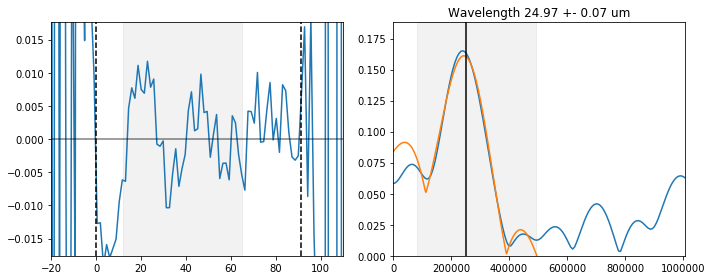

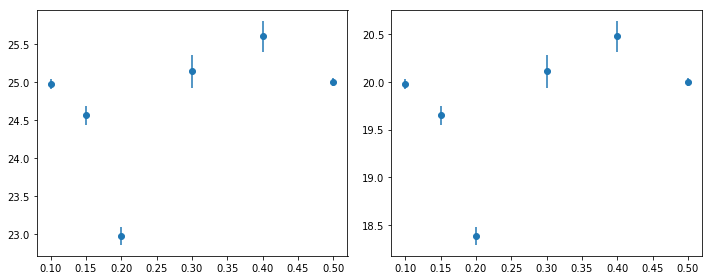

In [3703]:
# Compute Wavelength for all 

def fitfun(x, x0=0, amp=1, scale=1, offset=0, gradient=0):
    return amp * np.abs(np.sinc((x-x0) / scale)) + offset + gradient * x 

wavelengths = []
freq = np.unique(df_data.BoxShakeFreq)[0]

for i in range(len(movie[0])):
    # Get FT 
    c = tp.Curve(movie[1] * 1e-6, movie[2][:, i]).trim(xlim=z_lims)
    y_ft = fourier_transform(c, k)
    c_ft = tp.Curve(k, np.abs(y_ft) * 1e6)
    
    # Fit Sinc 
    guess = [twopi*freq / speed_sound_guess, c_ft.y.max(), twopi / (z_lims[1] - z_lims[0]), c_ft.maxy / 1000, c_ft.maxy / 100000]
    fit_lims = [guess[0] - 3 * twopi/L, guess[0] + 3 * twopi/L]
    fr, fe = c_ft.fit(fitfun, guess, plot=False, xlim=fit_lims)
    
    # Extract wavelength and error 
    wavelengths.append([twopi*1e6/fr[0], twopi*1e6 * fe[0]/fr[0]**2])
wavelengths = np.array(wavelengths)

## Test Plotter 
# Get FT 
c = tp.Curve(movie[1] * 1e-6, movie[2][:, test]).trim(xlim=z_lims)
y_ft = fourier_transform(c, k)
c_ft = tp.Curve(k, np.abs(y_ft) * 1e6)

# Fit Sinc 
guess = [twopi*freq / speed_sound_guess, c_ft.y.max(), twopi / (z_lims[1] - z_lims[0]), c_ft.maxy / 1000, c_ft.maxy / 100000]
fit_lims = [guess[0] - 3 * twopi/L, guess[0] + 3 * twopi/L]
fr, fe = c_ft.fit(fitfun, guess, plot=False, xlim=fit_lims,)

plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.plot(*tp.Curve(movie[1], movie[2][:, test]).data)
plt.axvline(0, c='k', linestyle='--', )
plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', )
plt.axhline(0, c='k', linestyle='-', alpha=0.5)
plt.axvspan(*z_lims*1e6, alpha=0.05, color='k', label='Fourier Width')
amp = np.max(np.abs(c.y)) * 1.5
plt.ylim([-amp, amp])
plt.xlim([-20, 110])

plt.subplot(122)
plt.plot(*c_ft.data)
plt.plot(*c_ft.xyfitplot)
plt.axvline(fr[0], c='k',)
plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
plt.ylim([0, None])
plt.xlim([0, fr[0]*4])
plt.title('Wavelength {:.2f} +- {:.2f} um'.format(twopi*1e6/fr[0], twopi*1e6 * fe[0]/fr[0]**2))
plt.tight_layout()

## Data Plotter 
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.errorbar(movie[0], wavelengths[:, 0], wavelengths[:, 1], fmt='o')
plt.subplot(122)
plt.errorbar(movie[0], freq*wavelengths[:, 0]/1e3, freq*wavelengths[:, 1]/1e3, fmt='o')
plt.tight_layout()

## Single Sided Decay Fits

In [3704]:
# Dataset Info 
speed_sound_guess = 20 * 1e-6/1e-3
fit_lims = [12, 65]
plot_lims = [-10, 100]

In [3705]:
# Single Sided Fit -- 0:DecayLength, 1:Wavelength, 2:Amplitude, 3:Phase, 4:Offset, 5:Gradient, 6:speed, 7:gamma 
def single_analyzer(c, freq, fit_lims, guess_wavelength, plot=False, plot_lims=[-10, 100]): 
    # Fit Exp Decay 
    guess = [50.0, guess_wavelength, 0.04, np.pi, 1e-2, 1e-4,]
    
    # Define Fit function 
    fit_vars = ['Decay Length [um]', 'Wavelength [um]', 'Amplitude at Wall', 'Phase at Wall', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
    speed_sound = [freq * fr[1] * 1e-6, freq * fe[1] * 1e-6]
    gamma = [speed_sound[0] / fr[0] / 1e-6, ((speed_sound[1] / (fr[0]*1e-6))**2 + (speed_sound[0] * fe[0] * 1e-6 / (fr[0]*1e-6)**2)**2)**(1/2)]
    
    #  resutls 
    if fr[2] < 0:
        fr[2] = - fr[2]
        fr[3] = fr[3] + np.pi
    fr[3] = np.mod(fr[3], twopi)
    
    
    # Print fit results 
    if plot:
        for i in range(len(fr)):
            print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

        print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
        print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))
    
    # Plot Results 
    if plot:
        plt.figure()
        plt.plot(*c.xyfitplot, 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
        amp = fr[2] * 1.5
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.tight_layout()
        
        plt.figure()
        plt.plot(c.x, c.y - fitfun_sin_decay(c.x, *fr), )
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.xlim(plot_lims)
        plt.ylim(-0.012, 0.012)
        plt.tight_layout()

    return [list(fr)+[speed_sound[0],gamma[0]], list(fe)+[speed_sound[1],gamma[1]]]

### Fit Averaged

-------------- 0.1 --------------
Decay Length [um] 	 32.0 +- 11.3
Wavelength [um] 	 25.5 +- 0.979
Amplitude at Wall 	 0.0199 +- 0.00688
Phase at Wall 	 3.57 +- 0.269
Offset           	 0.00128 +- 0.00191
Gradient          	 -2.48e-05 +- 4.4e-05

Speed of Sound   20.43 +- 0.78 um/ms
Decay Rate Gamma 101.62 +- 36.00 Hz


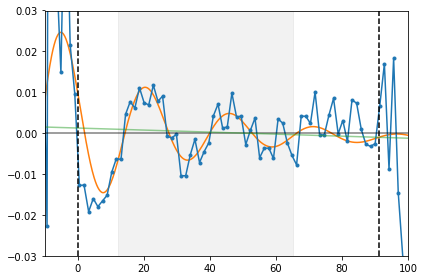

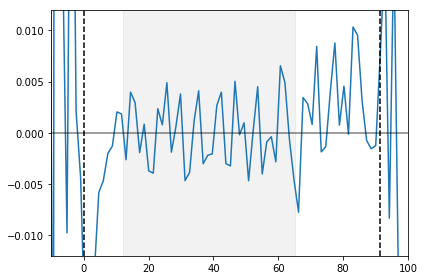

-------------- 0.15 --------------
Decay Length [um] 	 52.5 +- 23.7
Wavelength [um] 	 25.1 +- 0.727
Amplitude at Wall 	 0.0197 +- 0.0059
Phase at Wall 	 3.59 +- 0.241
Offset           	 0.00671 +- 0.00232
Gradient          	 -0.000162 +- 5.45e-05

Speed of Sound   20.07 +- 0.58 um/ms
Decay Rate Gamma 60.82 +- 27.49 Hz


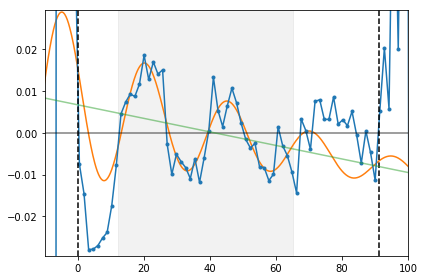

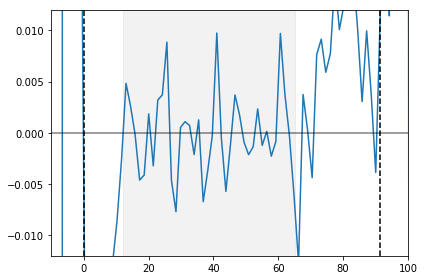

-------------- 0.2 --------------
Decay Length [um] 	 41.7 +- 12.8
Wavelength [um] 	 23.7 +- 0.596
Amplitude at Wall 	 0.0307 +- 0.00746
Phase at Wall 	 4.08 +- 0.211
Offset           	 -0.00124 +- 0.00269
Gradient          	 9.46e-05 +- 6.34e-05

Speed of Sound   18.92 +- 0.48 um/ms
Decay Rate Gamma 72.20 +- 22.24 Hz


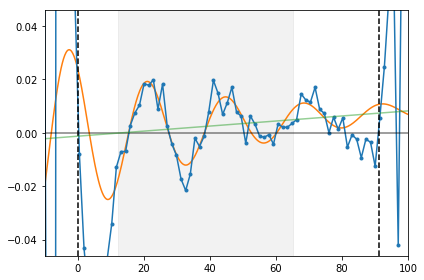

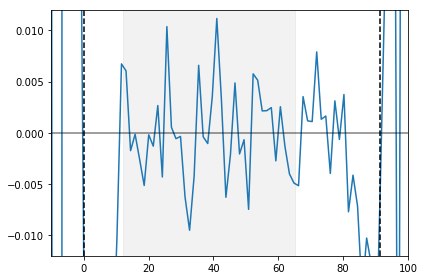

-------------- 0.3 --------------
Decay Length [um] 	 35.4 +- 6.82
Wavelength [um] 	 25.3 +- 0.473
Amplitude at Wall 	 0.0541 +- 0.00945
Phase at Wall 	 3.6 +- 0.137
Offset           	 -0.00397 +- 0.00286
Gradient          	 0.000105 +- 6.62e-05

Speed of Sound   20.25 +- 0.38 um/ms
Decay Rate Gamma 90.96 +- 17.58 Hz


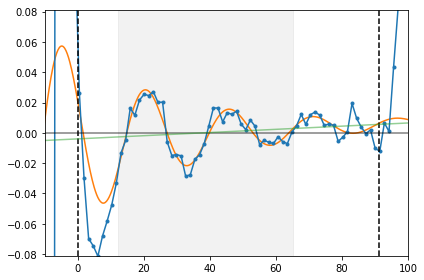

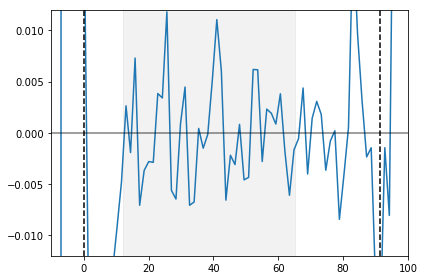

-------------- 0.4 --------------
Decay Length [um] 	 37.1 +- 6.02
Wavelength [um] 	 25.0 +- 0.379
Amplitude at Wall 	 0.0547 +- 0.00773
Phase at Wall 	 3.77 +- 0.115
Offset           	 -0.00653 +- 0.00247
Gradient          	 0.000213 +- 5.73e-05

Speed of Sound   20.02 +- 0.30 um/ms
Decay Rate Gamma 85.81 +- 13.97 Hz


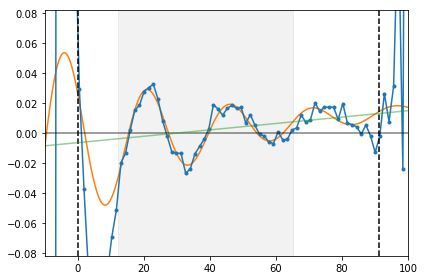

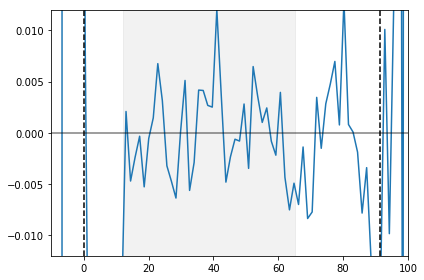

-------------- 0.5 --------------
Decay Length [um] 	 30.1 +- 4.47
Wavelength [um] 	 24.7 +- 0.442
Amplitude at Wall 	 0.0861 +- 0.0128
Phase at Wall 	 4.02 +- 0.131
Offset           	 -0.0142 +- 0.00356
Gradient          	 0.000391 +- 8.24e-05

Speed of Sound   19.73 +- 0.35 um/ms
Decay Rate Gamma 104.30 +- 15.58 Hz


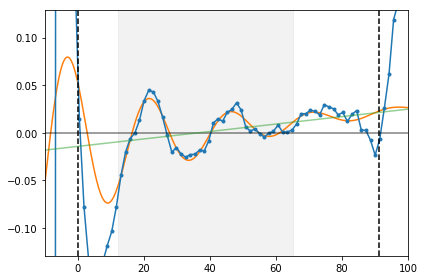

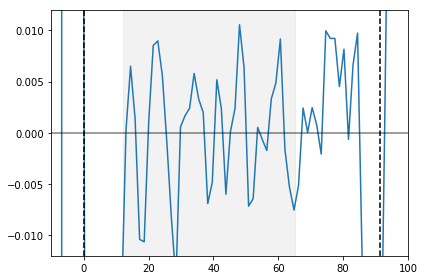

In [3706]:
# Fit and plot all data 
frs = []
fes = []
freq = np.unique(df_data['BoxShakeFreq'])[0]
movie = movie_dN_N
wavelength_guess = speed_sound_guess / freq


for i in range(len(movie[0])):
    print('-------------- {} --------------'.format(movie[0][i]))
    c = tp.Curve(movie[1].flatten(), movie[2][:, i].flatten())
    fr, fe = single_analyzer(c, freq, fit_lims, wavelength_guess*1e6, True, plot_lims)
    frs.append(fr)
    fes.append(fe)
    plt.show()
    
frs = np.array(frs)
fes = np.array(fes) 

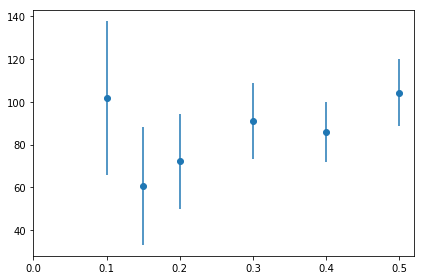

In [3707]:
# Plot Raw Results 
plot_res = 7

scales = [1, 1, 1, np.pi, 1, 1, 1e-3, twopi]
plt.errorbar(movie[0], frs[:, plot_res]/scales[plot_res], fes[:, plot_res]/scales[plot_res], fmt='o',)
# plt.ylim([0, None])
plt.xlim([0, None])
plt.tight_layout()

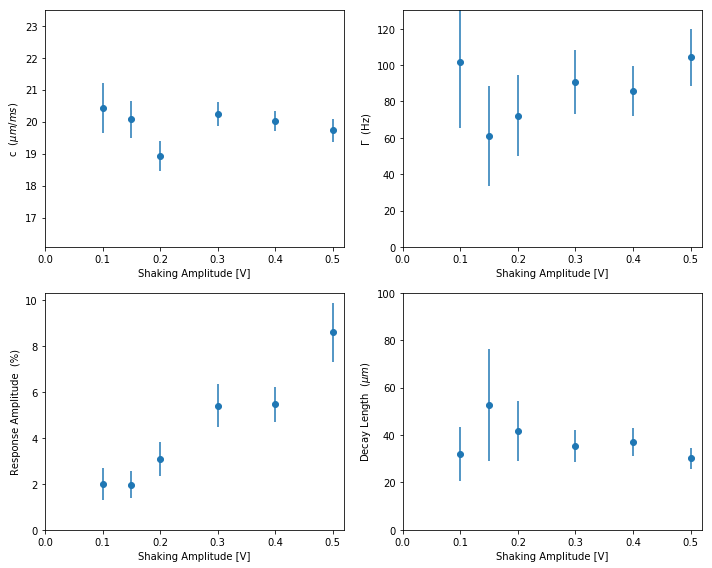

In [3708]:
c_lim = [0.85*np.min(frs[:, 6]*1e3), 1.15*np.max(frs[:, 6]*1e3)]
g_lim = [0, 1.25*np.max(frs[:, 7]/twopi)]
l_lim = [0, 100]

# c_lim = [15, 20]
# g_lim = [0, 120]

x = movie_dN[0].flatten()
amp_mult = 100
xp = frs[:, 2]*amp_mult

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[10, 8])
ax = ax.flatten()

ax[0].errorbar(x, frs[:, 6]*1e3, fes[:, 6]*1e3, fmt='o')
ax[0].set(ylabel=r'c  ($\mu m / ms$)', xlim=[0, None], ylim=c_lim, xlabel='Shaking Amplitude [V]')

ax[1].errorbar(x, frs[:, 7]/twopi, fes[:, 7]/twopi, fmt='o')
ax[1].set(ylabel=r'$\Gamma$  (Hz)', xlim=[0, None], ylim=g_lim, xlabel='Shaking Amplitude [V]')

ax[2].errorbar(x, frs[:, 2]*amp_mult, fes[:, 2]*amp_mult, fmt='o')
ax[2].set(ylabel=r'Response Amplitude  (%)', xlim=[0, None], ylim=[0, None], xlabel='Shaking Amplitude [V]')

ax[3].errorbar(x, frs[:, 0], fes[:, 0], fmt='o')
ax[3].set(ylabel=r'Decay Length  ($\mu m$)', ylim=l_lim, xlim=[0, None], xlabel='Shaking Amplitude [V]', )

plt.tight_layout()

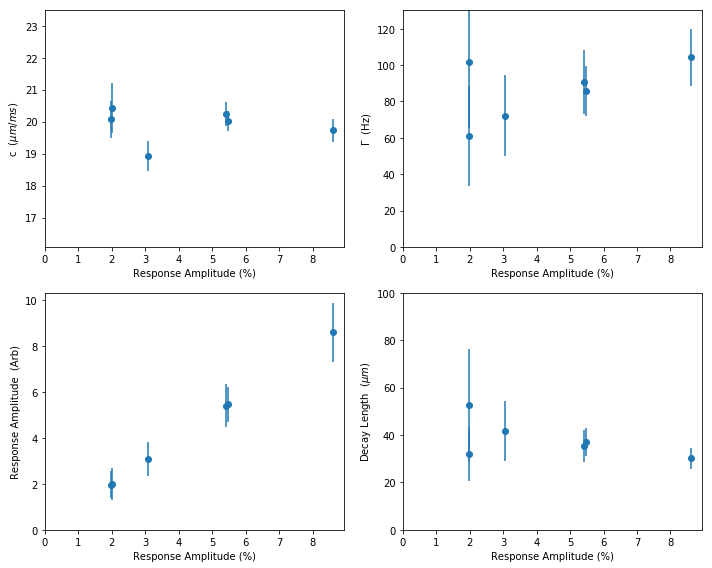

In [3709]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[10, 8])
ax = ax.flatten()

ax[0].errorbar(xp, frs[:, 6]*1e3, fes[:, 6]*1e3, fmt='o')
ax[0].set(xlabel = r'Response Amplitude (%)', xlim=[0, None], ylabel=r'c  ($\mu m / ms$)', ylim=c_lim)

ax[1].errorbar(xp, frs[:, 7]/twopi, fes[:, 7]/twopi, fmt='o')
ax[1].set(xlabel = r'Response Amplitude (%)', xlim=[0, None], ylabel=r'$\Gamma$  (Hz)', ylim=g_lim)

ax[2].errorbar(xp, frs[:, 2]*amp_mult, fes[:, 2]*amp_mult, fmt='o')
ax[2].set(xlabel = r'Response Amplitude (%)', xlim=[0, None], ylabel=r'Response Amplitude  (Arb)', ylim=[0, None])

ax[3].errorbar(xp, frs[:, 0], fes[:, 0], fmt='o')
ax[3].set(xlabel = r'Response Amplitude (%)', xlim=[0, None], ylabel=r'Decay Length  ($\mu m$)', ylim=l_lim)

plt.tight_layout()

### Fit Varying Cutoff 

In [2484]:
fit_lims_various = [[7, 60], [9, 60], [11, 60], [13, 60],
                    [7, 64], [9, 64], [11, 64], [13, 64],
                    [7, 68], [9, 68], [11, 68], [13, 68], ]

In [2485]:
# Fit and plot all data 
frs = []
fes = []
x_all = []
freq = np.unique(df_data['BoxShakeFreq'])[0]
movie = movie_dN_N
wavelength_guess = speed_sound_guess / freq

for fit_lims_ in fit_lims_various:
    for i in range(len(movie[0])):
        c = tp.Curve(movie[1].flatten(), movie[2][:, i].flatten())
        fr, fe = single_analyzer(c, freq, fit_lims_, wavelength_guess*1e6, False)
        frs.append(fr)
        fes.append(fe)
        x_all.append(movie[0][i])
    
frs = np.array(frs)
fes = np.array(fes) 
x_all = np.array(x_all)

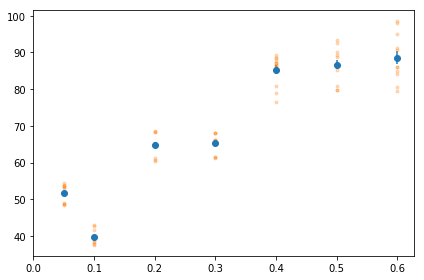

In [1456]:
plot_res = 7

scales = [1, 1, 1, np.pi, 1, 1, 1e-3, twopi]
plt.errorbar(*bin_data(x_all, frs[:, plot_res]/scales[plot_res])[0:3], fmt='o')
plt.plot(x_all, frs[:, plot_res]/scales[plot_res], '.', alpha=0.25)
# plt.ylim([0, None])
plt.xlim([0, None])
plt.tight_layout()

### Fit Raw

In [1350]:
# Fit and plot all data 
frs = []
fes = []
freq = np.unique(df_data['BoxShakeFreq'])[0]
movie = movie_dN_N_raw
wavelength_guess = speed_sound_guess / freq


for i in range(len(movie[0])):
    c = tp.Curve(movie[1].flatten(), movie[2][:, i].flatten())
    fr, fe = single_analyzer(c, freq, fit_lims, wavelength_guess*1e6, False, plot_lims)
    frs.append(fr)
    fes.append(fe)
    
frs = np.array(frs)
fes = np.array(fes)   

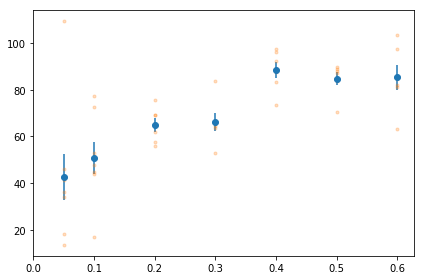

In [1351]:
# Plot Raw Results 
plot_res = 7

scales = [1, 1, 1, np.pi, 1, 1, 1e-3, twopi]
plt.errorbar(*bin_data(movie[0], frs[:, plot_res]/scales[plot_res])[0:3], fmt='o')
plt.plot(movie[0], frs[:, plot_res]/scales[plot_res], '.', alpha=0.25)
# plt.ylim([0, 150])
plt.xlim([0, None])
plt.tight_layout()

### Fit with Fixed Wavelength

In [2563]:
# Single Sided Fit -- 0:DecayLength, 1:Amplitude, 2:Phase, 3:Offset, 4:Gradient, 5:gamma 

def single_analyzer_fixed_wavelength(c, freq, wavelength, fit_lims, plot=False, plot_lims=[-10, 100]): 
    # Fit Exp Decay 
    guess = [50.0, 0.04, np.pi, 1e-2, 1e-4,]
    
    # Define Fit function 
    fit_vars = ['Decay Length [um]', 'Amplitude at Wall', 'Phase at Wall', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
    speed_sound = [freq * wavelength * 1e-6, 0]
    gamma = [speed_sound[0] / fr[0] / 1e-6, ((speed_sound[1] / (fr[0]*1e-6))**2 + (speed_sound[0] * fe[0] * 1e-6 / (fr[0]*1e-6)**2)**2)**(1/2)]
    
    #  resutls 
    if fr[1] < 0:
        fr[1] = - fr[1]
        fr[2] = fr[2] + np.pi
    fr[2] = np.mod(fr[2], twopi)
    
    # Print fit results 
    if plot:
        for i in range(len(fr)):
            print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

        print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
        print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))
    
    # Plot Results 
    if plot:
        plt.figure()
        plt.plot(*c.xyfitplot, 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 0, *fr[2:]]), 'C2-', alpha=0.5)
        amp = fr[1] * 1.5
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.tight_layout()

    return [list(fr)+[gamma[0]], list(fe)+[gamma[1]]]

-------------- 0.05 --------------
X and Y limits given leads to too little points. All are being used
Decay Length [um] 	 2.89e+07 +- 7.73e+12
Amplitude at Wall 	 0.221 +- 0.227
Phase at Wall 	 5.87 +- 0.791
Offset           	 0.0112 +- 0.159
Gradient          	 0.00217 +- 0.00225

Speed of Sound   15.40 +- 0.00 um/ms
Decay Rate Gamma 0.00 +- 22.64 Hz


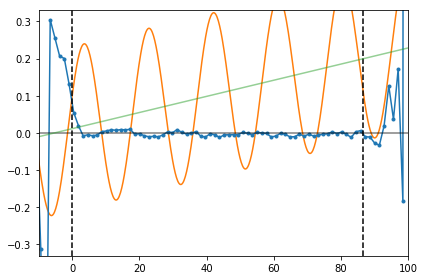

-------------- 0.1 --------------
X and Y limits given leads to too little points. All are being used
Decay Length [um] 	 -80.3 +- 76.8
Amplitude at Wall 	 0.138 +- 0.178
Phase at Wall 	 5.83 +- 0.441
Offset           	 0.0187 +- 0.142
Gradient          	 0.00256 +- 0.00201

Speed of Sound   15.46 +- 0.00 um/ms
Decay Rate Gamma -30.63 +- 29.30 Hz


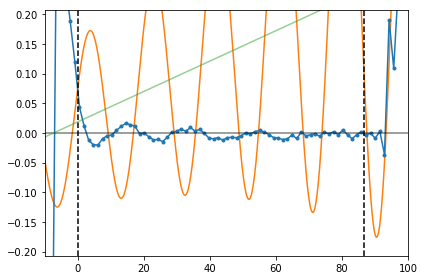

-------------- 0.15 --------------
X and Y limits given leads to too little points. All are being used
Decay Length [um] 	 4.63e+07 +- 1.81e+13
Amplitude at Wall 	 0.659 +- 0.593
Phase at Wall 	 5.75 +- 0.694
Offset           	 0.0716 +- 0.417
Gradient          	 0.0065 +- 0.00589

Speed of Sound   15.51 +- 0.00 um/ms
Decay Rate Gamma 0.00 +- 20.78 Hz


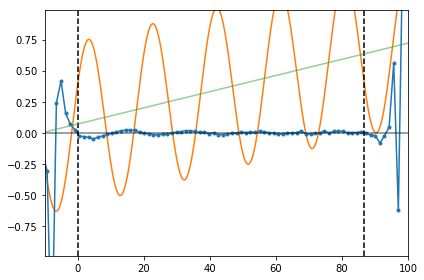

-------------- 0.2 --------------
X and Y limits given leads to too little points. All are being used
Decay Length [um] 	 -76.6 +- 86.6
Amplitude at Wall 	 0.166 +- 0.266
Phase at Wall 	 5.5 +- 0.518
Offset           	 0.0503 +- 0.215
Gradient          	 0.00317 +- 0.00306

Speed of Sound   15.70 +- 0.00 um/ms
Decay Rate Gamma -32.60 +- 36.84 Hz


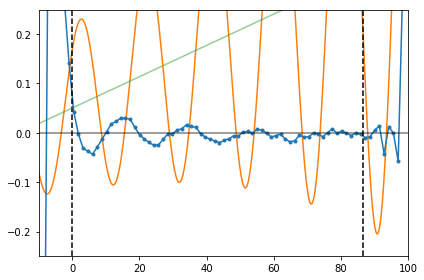

-------------- 0.3 --------------
X and Y limits given leads to too little points. All are being used
Decay Length [um] 	 -64.9 +- 76.8
Amplitude at Wall 	 0.0369 +- 0.0761
Phase at Wall 	 1.54 +- 0.584
Offset           	 -0.0416 +- 0.0681
Gradient          	 -0.000866 +- 0.000968

Speed of Sound   15.88 +- 0.00 um/ms
Decay Rate Gamma -38.93 +- 46.07 Hz


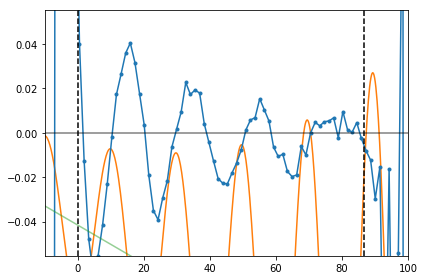

-------------- 0.4 --------------
X and Y limits given leads to too little points. All are being used
Decay Length [um] 	 4.42e+07 +- 9.48e+12
Amplitude at Wall 	 0.0829 +- 0.0482
Phase at Wall 	 4.74 +- 0.453
Offset           	 0.0194 +- 0.0342
Gradient          	 0.00048 +- 0.000484

Speed of Sound   16.08 +- 0.00 um/ms
Decay Rate Gamma 0.00 +- 12.42 Hz


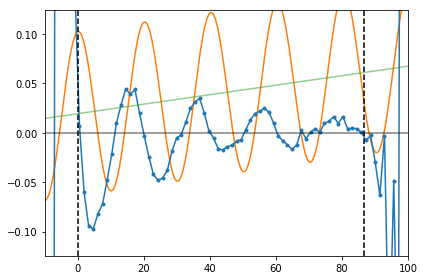

-------------- 0.5 --------------
X and Y limits given leads to too little points. All are being used
Decay Length [um] 	 1.97e+07 +- 2.13e+12
Amplitude at Wall 	 0.122 +- 0.0898
Phase at Wall 	 3.96 +- 0.557
Offset           	 0.00484 +- 0.0626
Gradient          	 0.00132 +- 0.000883

Speed of Sound   16.37 +- 0.00 um/ms
Decay Rate Gamma 0.00 +- 14.29 Hz


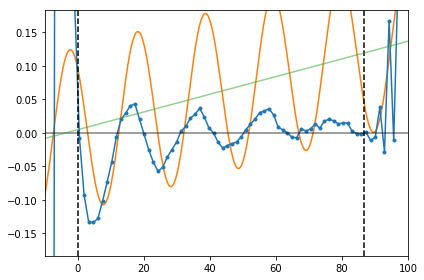

In [2564]:
# Fit and plot all data 
frs = []
fes = []
freq = np.unique(df_data['BoxShakeFreq'])[0]
movie = movie_dN_N
wavelength_guess = speed_sound_guess / freq


for i in range(len(movie[0])):
    print('-------------- {} --------------'.format(movie[0][i]))
    c = tp.Curve(movie[1].flatten(), movie[2][:, i].flatten())
    fr, fe = single_analyzer_fixed_wavelength(c, freq, wavelengths[i, 0], fit_lims, True, plot_lims)
    frs.append(fr)
    fes.append(fe)
    plt.show()
    
frs = np.array(frs)
fes = np.array(fes) 

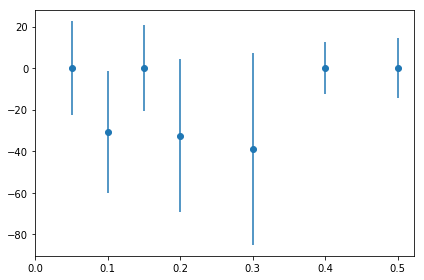

In [2565]:
# Plot Raw Results 
plot_res = 5

scales = [1, 1, np.pi, 1, 1, twopi]
plt.errorbar(movie[0], frs[:, plot_res]/scales[plot_res], fes[:, plot_res]/scales[plot_res], fmt='o',)
# plt.ylim([0, None])
plt.xlim([0, None])
plt.tight_layout()

### Plots

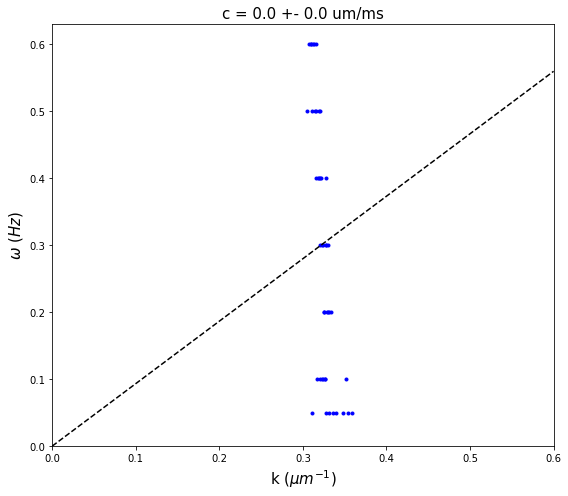

In [1337]:
# omega vs k 
binned = bin_data(movie[0], twopi/frs[:, 1])
c = tp.Curve(binned[1], binned[0])
line = lambda x, m:  m*x
fr, fe = c.fit(line, [0,], plot=False)

plt.figure(figsize=(8, 7))
plt.plot(twopi/frs[:, 1], movie[0], 'b.')
plt.plot(np.linspace(0, 0.6, 100), line(np.linspace(0, 0.6, 100), fr[0]), 'k--')
plt.ylim([0, None])
plt.xlim([0, 0.6])
plt.ylabel(r'$\omega$ ($Hz$)', fontsize=15)
plt.xlabel(r'k $(\mu m^{-1})$', fontsize=15)
plt.title('c = {:.1f} +- {:.1f} um/ms'.format(fr[0]*twopi/1e3, fe[0]*twopi/1e3), fontsize=15)
plt.tight_layout()

## Temporary Store Data

In [2994]:
# collector = dict()

In [3442]:
# collector['2A'] = [frs, fes]
# collector['2B'] = [frs, fes]
# collector['2C'] = [frs, fes]
# collector['2D'] = [frs, fes]
# collector['2E'] = [frs, fes]

In [3443]:
list(collector.keys())

['2A', '2B', '2E', '2D', '2C']

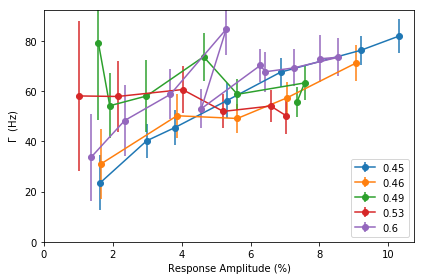

In [3444]:
keys = ['2A','2D','2C','2B', '2E']
vals = [0.45, 0.46, 0.49, 0.53, 0.6]

fig, ax = plt.subplots()

for i,k in enumerate(keys):
    frs, fes = collector[k]
    amp_mult = 100
    xp = frs[:, 2]*amp_mult
    
    ax.errorbar(xp, frs[:, 7]/twopi, fes[:, 7]/twopi, fmt='o-', label='{}'.format(vals[i]))
    ax.set(xlabel = r'Response Amplitude (%)', xlim=[0, None], ylabel=r'$\Gamma$  (Hz)', ylim=[0, None])
plt.legend()
plt.tight_layout()

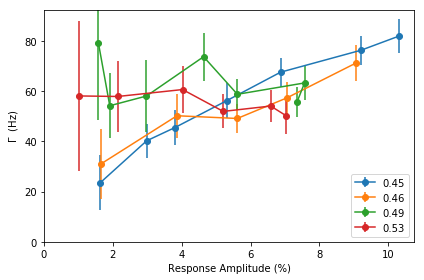

In [3026]:
keys = ['2A','2D','2C','2B']
vals = [0.45, 0.46, 0.49, 0.53]

fig, ax = plt.subplots()

for i,k in enumerate(keys):
    frs, fes = collector[k]
    amp_mult = 100
    xp = frs[:, 2]*amp_mult
    
    ax.errorbar(xp, frs[:, 7]/twopi, fes[:, 7]/twopi, fmt='o-', label='{}'.format(vals[i]))
    ax.set(xlabel = r'Response Amplitude (%)', xlim=[0, None], ylabel=r'$\Gamma$  (Hz)', ylim=[0, None])
plt.legend()
plt.tight_layout()